In [41]:
import os, sys
sys.path.append('../')
from osqtoolz import *
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import seaborn as sns
import tldextract
from urllib.parse import urlparse
import math
%matplotlib inline
train = pd.read_csv('./data/train.csv')
checkna(train)
train.head()

2797/3000 (93%) rows contain NaNs, in 13 columns:
id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [42]:
import tldextract
from urllib.parse import urlparse
import math

train = train.pipe(date_feature, col='release_date')
def homepage_func(x):
    if type(x) == str:
        x1 = tldextract.extract(x)
        x2 = urlparse(x)
        return 'domain_{}'.format(x1[1]), len([i for i in x2[2].split('/') if len(i) > 0])
    elif np.isnan(x):
        return 'domain_no_value', 0
    else:
        raise Exception('weird value', x)
tmp = train['homepage'].apply(homepage_func)
domains = pd.Series([i[0] for i in tmp])
subcount = pd.Series([i[1] for i in tmp])
domain_counts = pd.Series(domains).value_counts()
def domain_freq(x):
    if domain_counts[x] == 1:
        return 'domain_lone_value'
    else:
        return x
train['domain'] = domains.apply(domain_freq)
train = pd.concat([pd.get_dummies(train.domain), train.drop('domain', axis=1)], axis=1)

langs = set()
def lang_func(x):
    try:
        out = [x['name'].lower() for x in json.loads(x.replace("'", '"'))]
        out = [x for x in out if x not in ['no language', '']]
        langs.update(out)
        return out
    except:
        return []
lang_series = train.spoken_languages.apply(lang_func)
for lang in langs:
    train['lang_{}'.format(lang)] = lang_series.apply(lambda x: np.uint8(1) if lang in x else np.uint8(0)).astype(np.uint8)

def json_func(x):
    try:
        return 'coll_{}'.format(json.loads(x.replace("'", '"'))[0]['name'].lower())
    except:
        return np.nan
train.belongs_to_collection = train.belongs_to_collection.apply(json_func)
value_counts = train.belongs_to_collection.dropna().value_counts()
def count_func(x):
    if type(x) == str:
        if value_counts[x] > 1:
            return x
        else:
            return ''
    elif np.isnan(x):
        return ''
    else:
        raise Exception("Unknown value", x)
def make_len_feature(col_name):
    train['{}_len'.format(col_name)] = train[col_name].apply(lambda x: len(x) if type(x) == str else x)
    len_mean = int(math.ceil(train['{}_len'.format(col_name)].mean()))
    train['{}_len'.format(col_name)] = train['{}_len'.format(col_name)].apply(lambda x: len_mean if np.isnan(x) else x)
train.belongs_to_collection = train.belongs_to_collection.apply(count_func)
train = pd.concat([pd.get_dummies(train.belongs_to_collection), train], axis=1)
train['num_id'] = train.imdb_id.apply(lambda x: int(x[2:]))
for col in ['original_title', 'title', 'tagline', 'overview', 'title']:
    make_len_feature(col)
train.original_language = train.original_language.apply(lambda x: 'orig_lang_{}'.format(x))
train = pd.concat([pd.get_dummies(train.original_language), train], axis=1)
train['status_int'] = train.status.apply(lambda x: 1 if x == 'Released' else 0)
train.runtime = train.runtime.apply(lambda x: train.runtime.mean() if np.isnan(x) else x)

companies = set()
def company_func(x):
    try:
        out = [x['name'].lower() for x in json.loads(x.replace("'", '"'))]
        out = [x for x in out if x not in ['no companies', '']]
        companies.update(out)
        return out
    except:
        return []
company_series = train.production_companies.apply(company_func)
for company in companies:
    train['company_{}'.format(company)] = company_series.apply(lambda x: np.uint8(1) if company in x else np.uint8(0)).astype(np.uint8)
company_sums = {}
for company in companies:
    company_sums[company] = train['company_{}'.format(company)].sum()
company_sums = pd.Series(company_sums)
print("Total companies: {}".format(len(company_sums)))
top_100 = company_sums.sort_values(ascending=False).head(n=100)
for company in companies:
    col = 'company_{}'.format(company)
    if col not in top_100:
        train.drop(col, axis=1, inplace=True)
#print("Top 10 companies:")
#print(company_sums.sort_values(ascending=False).head(n=10))

# TODO: cast, crew, Keywords, genres, production_companies, production_countries
train = train.drop(['spoken_languages','original_language', 'belongs_to_collection', 'original_title', 'imdb_id', 'cast', 'crew', 'Keywords', 'title', 'tagline', 'status', 'genres', 'homepage', 'id', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date'], axis=1)
train.head()

Total companies: 3581


,orig_lang_ar,orig_lang_bn,orig_lang_cn,orig_lang_cs,orig_lang_da,orig_lang_de,orig_lang_el,orig_lang_en,orig_lang_es,orig_lang_fa,...,lang_한국어/조선말,lang_deutsch,lang_italiano,lang_català,num_id,original_title_len,title_len,tagline_len,overview_len,status_int
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,2637294,22,22,52.0,155.0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,368933,40,40,60.0,393.0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,2582802,8,8,47.0,130.0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1821480,7,7,45.0,581.0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1380152,4,10,45.0,168.0,1


In [48]:
list(train.columns)

['orig_lang_ar',
 'orig_lang_bn',
 'orig_lang_cn',
 'orig_lang_cs',
 'orig_lang_da',
 'orig_lang_de',
 'orig_lang_el',
 'orig_lang_en',
 'orig_lang_es',
 'orig_lang_fa',
 'orig_lang_fi',
 'orig_lang_fr',
 'orig_lang_he',
 'orig_lang_hi',
 'orig_lang_hu',
 'orig_lang_id',
 'orig_lang_it',
 'orig_lang_ja',
 'orig_lang_ko',
 'orig_lang_ml',
 'orig_lang_mr',
 'orig_lang_nb',
 'orig_lang_nl',
 'orig_lang_no',
 'orig_lang_pl',
 'orig_lang_pt',
 'orig_lang_ro',
 'orig_lang_ru',
 'orig_lang_sr',
 'orig_lang_sv',
 'orig_lang_ta',
 'orig_lang_te',
 'orig_lang_tr',
 'orig_lang_ur',
 'orig_lang_vi',
 'orig_lang_zh',
 '',
 'coll_... has fallen collection',
 'coll_48 hrs. collection',
 'coll_[rec] collection',
 'coll_ace ventura collection',
 'coll_airport collection',
 'coll_alex cross collection',
 'coll_alien collection',
 'coll_american pie collection',
 'coll_asterix and obelix collection',
 'coll_atlas shrugged collection',
 'coll_back to the future collection',
 'coll_batman collection',
 'co

In [43]:
import catboost as ctb
from sklearn.linear_model import RidgeCV
cat = ctb.CatBoostRegressor(verbose=False, loss_function="RMSE")
rcv = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=5)

In [44]:
train = train.sample(frac=1)
X_train = train.drop('revenue', axis=1).values
y_train = np.log1p(train.revenue.values)

R2: 0.10714921198383365
RMSE: 2.0829063817141944


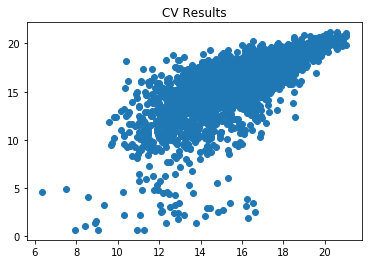

In [45]:
train_regressor(cat, X_train, y_train)